<a href="https://colab.research.google.com/github/Aramis84/Keras-practice/blob/master/Keras_Skip_Gram_Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!ls '/content/gdrive/MyDrive/Colab_Work/Colab Notebooks/'

Trial_1.ipynb


In [4]:
import keras 
from keras.datasets import imdb
from keras.preprocessing import text

from keras_preprocessing.sequence import pad_sequences
from keras.models import Model
from keras import optimizers
from keras.layers import Input, Dense, Reshape, dot, Embedding, Dot, Dropout
from keras.preprocessing.sequence import skipgrams
from keras.preprocessing.sequence import make_sampling_table
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import os
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')
import string

import gensim
from gensim.models.phrases import Phraser, Phrases

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
from nltk.corpus import gutenberg

### Sentence tokenization of the corpus

In [7]:
sent_tokens = gutenberg.sents()
type(sent_tokens)

nltk.corpus.reader.util.ConcatenatedCorpusView

### Pre-Processing

In [8]:
def pre_process(data, lower_case_flag = True, stop_wrds_flag = True, custom_stop_wrds = None, stemming_flag = False, bigrams_flag = True, min_count = 32, threshold = 64):
  sent_list = []
  if stop_wrds_flag:
      stopwrds = stopwords.words('english') + list(string.punctuation)
      if custom_stop_wrds is not None:
        stopwrds += custom_stop_wrds
  else:
    if custom_stop_wrds is not None:
      stopwrds = custom_stop_wrds + list(string.punctuation)
    else:
      stopwrds = list(string.punctuation)

  if lower_case_flag:
    for s in data:
      sent_list.append([w.lower() for w in s if w.lower() not in stopwrds])
  else:
    for s in data:
      sent_list.append([w for w in s if w.lower() not in stopwrds])

  if stemming_flag:
    stemmer = PorterStemmer()
    sent_list_stem = []
    for s in sent_list:
      sent_list_stem.append([stemmer.stem(w.lower()) for w in s])
    sent_list = sent_list_stem

  if bigrams_flag:
    bigrams_obj = Phraser(Phrases(sent_list, min_count = min_count, threshold = threshold))
  
  clean_sent = []
  for s in sent_list:
    clean_sent.append(bigrams_obj[s])


  return clean_sent

In [9]:
clean_sent = pre_process(sent_tokens, stemming_flag = False)

In [10]:
type(clean_sent), len(clean_sent)

(list, 98552)

In [11]:
# All vocab size
all_vocab = []
for s in clean_sent:
  all_vocab += s
len(set(all_vocab))

42252

### Word2Vec Model

In [12]:
# Hyper-params
window_size = 9
vocab_size = 5000 # vocabulary size
embed_vect_dim = 96
n_dense = 32
dropout_rate = 0.3
epochs = 4


In [13]:
def extract_text_mapping(list_of_texts, vocab_size = 10000):
    '''Should count number of times a word occurs in the vocabulary, assign integers to each word, 
    dictionary mapping between words and integers and reverse dictionary'''
    
    # Removing special characters and numbers from tokens
    filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n' + '0123456789'
    tokenizer = text.Tokenizer(num_words = vocab_size, filters = filters)
    
    tokenizer.fit_on_texts(list_of_texts)
        
    word_to_int_dict = tokenizer.word_index
    int_to_word_dict = {}
    int_to_word_dict = {val:key for key, val in word_to_int_dict.items()}
    data_in_int = tokenizer.texts_to_sequences(list_of_texts)
            
    word_to_int_dict['oov'] = 0
    int_to_word_dict[0] = 'oov'
    
    assert len(data_in_int) == len(list_of_texts), 'Length of data in integers do not match number \
    of original texts'
    return data_in_int, list_of_texts, word_to_int_dict, int_to_word_dict

In [14]:
data_in_int, text_list, wi_dict, iw_dict = extract_text_mapping(clean_sent, vocab_size = vocab_size)
len(iw_dict), len(wi_dict), len(data_in_int), len(text_list)

(42253, 42253, 98552, 98552)

### Set up the the NN architecture

In [15]:

sampling_table = make_sampling_table(vocab_size, sampling_factor = 0.1)
len(sampling_table)

5000

In [16]:
skip_grams = [skipgrams(s, vocabulary_size = vocab_size, window_size = window_size, negative_samples = 1., sampling_table = sampling_table) for s in data_in_int if len(s) >= window_size]
                

In [17]:
len(skip_grams)

43664

In [18]:
type(skip_grams[0]), len(skip_grams[0])

(tuple, 2)

In [19]:
input_length = 1
embed_layer = Embedding(input_dim = vocab_size, output_dim = embed_vect_dim, input_length = input_length)

target_ip = Input((1,)) # Sending in a single integer for the target word
context_ip = Input((1,)) # Sending in a single integer for the context word

# Get the Keras tensors 
target_tensor = embed_layer(target_ip)
target_tensor_reshaped = Reshape((embed_vect_dim, 1))(target_tensor) # Reshaping to a column vector

context_tensor = embed_layer(context_ip)
context_tensor_reshaped = Reshape((embed_vect_dim, 1))(context_tensor) # Reshaping to a column vector

cos_sim = Dot(axes = 1, normalize = True)([target_tensor_reshaped, context_tensor_reshaped])
cos_sim_num = Dot(axes = 1, normalize = False)([target_tensor_reshaped, context_tensor_reshaped])
cos_sim, cos_sim_num

(<KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'dot')>,
 <KerasTensor: shape=(None, 1, 1) dtype=float32 (created by layer 'dot_1')>)

In [20]:
cos_sim_reshaped = Reshape((1,))(cos_sim_num) # Single scalar

# Sigmoid output layer
dense_layer = Dense(n_dense, activation = 'relu')(cos_sim_reshaped)
dropout_layer = Dropout(rate = dropout_rate)(dense_layer)
output = Dense(1, activation = 'sigmoid')(dropout_layer)

model = Model(inputs = [target_ip, context_ip], outputs = output)
ada = optimizers.Adam()
model.compile(loss = 'binary_crossentropy', optimizer= ada)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 96)        480000      input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 96, 1)        0           embedding[0][0]              

In [21]:
# Model that takes in target and context word indices and outputs the cosine similarity.
# This model is not trained, No need to compile
check_model = Model(inputs = [target_ip, context_ip], outputs = cos_sim)

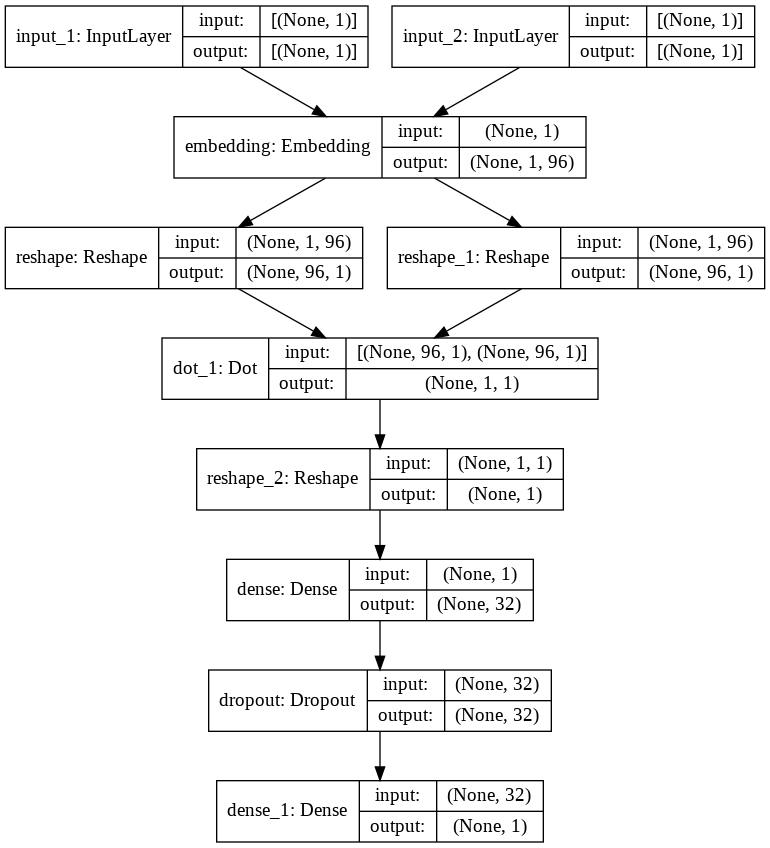

In [22]:
plot_model(model, show_shapes = True, show_layer_names = True)

In [23]:
class WordSimCallBack(keras.callbacks.Callback):
    
    def __init__(self, top_n = 5):
        self.top_n = top_n
    
    def top_sim_words(self):
        all_sim  = np.zeros((vocab_size))
        target_index = np.zeros((1,))
        context_index = np.zeros((1,))
         
        for ii in valid_examples:
        
            target_index[0,] = ii

            for kk in range(vocab_size):
                context_index[0,] = kk
                all_sim[kk] = check_model.predict_on_batch([target_index, context_index])

            # Sorting in ascending order and taking the last top_n ones
            closest_sim_words = all_sim.argsort()[::-1]# These are the integer indices

            # Getting the words corresponding to the integer indices
            closest_words_list = []
            
            cc = 0
            for jj in closest_sim_words[1:]:
                if cc <= self.top_n:
                    word = iw_dict[jj]
                    if (word not in stopwords.words('english')) and (len(word) > 2):
                        closest_words_list.append(word)
                        cc += 1
       
            print('Target word : {} -> {}'.format(iw_dict[ii], closest_words_list))


interested_words = ['mother', 'husband', 'dog', 'morning', 'love']
valid_examples = [wi_dict[word] for word in interested_words]
cb = WordSimCallBack()

### Training

In [ ]:
for e in range(epochs):
    epoch_loss = 0
    for ind, val in enumerate(tqdm(skip_grams)):

        target_word = np.array(list(zip(*val[0]))[0], dtype = 'int32')
        context_word = np.array(list(zip(*val[0]))[1], dtype = 'int32')
        labels = np.array(val[1], dtype = 'int32')
        X = [target_word, context_word] # batch shape (None, 1) for each target and context
        epoch_loss += model.train_on_batch(X, labels)
    
    print('After epoch {}/{} -> loss = {}'.format(e+1, epochs, epoch_loss))
    cb.top_sim_words()
    
    # wts = model.get_weights()[0]
    # iw_dict_vocab = dict(itertools.islice(iw_dict.items(), vocab_size))
    # df_wts = pd.DataFrame(wts, index = iw_dict_vocab.values())
    # df_wts.to_csv('df'+ file_name, header = False, index = True)
    # savetxt('just' + file_name, wts, delimiter = ',')
    print('Embeddings saved post epoch {}'.format(e+1))
    print('+++++++++++++++++++++++++++++++++++')

100%|██████████| 43664/43664 [07:45<00:00, 93.73it/s]


After epoch 1/4 -> loss = 22613.532455682755
